
# **COMP9414 Artificial Intelligence**
## Assignment 1: Constraint Satisfaction Search

@Authors: **Wayne Wobcke, Alfred Krzywicki, Stefano Mezza**

**Due Date:** Week 5, Friday, October 11, 5.00pm

### Objective

This assignment concerns developing optimal solutions to a scheduling problem inspired by the scenario of hosting a number of visitors to an organization such as a university department. Each visitor must have a number of meetings, however there are both *constraints* on availability (of rooms and hosts), and *preferences* of each visitor for the days and times of each meeting. Some of the constraints are “hard” constraints (cannot be violated in any solution), while the preferences are “soft” constraints (can be satisfied to more or less degree). Each soft constraint has a cost function giving the “penalty” for scheduling the meeting at a given time (*lower* costs are preferred). The aim is to schedule all the required meetings so that the sum total of all the penalties is *minimized*, and all the constraints are satisfied.

More technically, this assignment is an example of a *constraint optimization problem*, a problem that has constraints like a standard Constraint Satisfaction Problem (CSP), but also *costs* associated with each solution. For this assignment, we will use a *greedy* algorithm to find optimal solutions to visitor hosting problems that are specified as text strings. However, unlike the greedy search algorithm described in the lectures on search, this greedy algorithm has the property that it is guaranteed to find an optimal solution for any problem (if a solution exists).

The assignment will use the AIPython code of Poole & Mackworth. You are given code to translate visitor hosting problems specified as text strings into CSPs with a cost, and you are given code for several constraint solving algorithms &ndash; based on domain splitting and arc consistency, and based on depth-first search. The assignment will be to implement some missing procedures and to analyse the performance of the constraint solving methods, both analytically and experimentally.

### Submission Instructions

- This is an individual assignment.

- Submit **this** Jupyter notebook on the CSE give system (or vlab) using the following command: **give cs9414 ass1 ass1.ipynb**

- This means that the Jupyter notebook file **must** be called ``ass1.ipynb``.

- Make sure you set up AIPython (as done below) so the code can be run on either CSE machines or a marker's own machine.

- Do not submit any AIPython code. Hence do not change any AIPython code to make your code run.

- Make sure your notebook runs cleanly (restart the kernel and run each cell to check).

- Do not modify the existing code in this notebook except to answer the questions. Marks will be given as and where indicated.

- If you want to submit additional code (e.g. for generating plots), add that at the end of the notebook.

- **Do not distribute any of this code on the Internet.**

### Late Penalties

Standard UNSW late penalties apply.

### Plagiarism

Remember that ALL work submitted for this assignment must be your own work and no sharing or copying of code or answers is allowed. You may discuss the assignment with other students but must not collaborate on developing answers to the questions. You may use code from the Internet only with suitable attribution of the source. You may not use ChatGPT or any similar software to generate any part of your explanations, evaluations or code. Do not use public code repositories on sites such as github or file sharing sites such as Google Drive to save any part of your work &ndash; make sure your code repository or cloud storage is private and do not share any links. This also applies after you have finished the course, as we do not want next year’s students accessing your solution, and plagiarism penalties can still apply after the course has finished.

All submitted assignments will be run through plagiarism detection software to detect similarities to other submissions, including from past years. You should **carefully** read the UNSW policy on academic integrity and plagiarism (linked from the course web page), noting, in particular, that collusion (working together on an assignment, or sharing parts of assignment solutions) is a form of plagiarism.

Finally, do not use any contract cheating “academies” or online “tutoring” services. This counts as serious misconduct with heavy penalties up to automatic failure of the course with 0 marks, and expulsion from the university for repeat offenders.

### The Visitor Hosting Problem

A CSP for this assignment is a set of variables representing meetings, binary constraints on pairs of meetings, and unary constraints (hard or soft) on meetings. The domains are all working hours in one week, and meetings are all assumed to be 1 hour duration. Days are represented (in the input and output) as strings ‘mon’, ‘tue’, ‘wed’, ‘thu’ and ‘fri’, and times are represented as strings ‘9am’, ‘10am’, ‘11am’, ‘12pm’, ‘1pm’, ‘2pm’, ‘3pm’ and ‘4pm’. The only possible values are a combination of a day and time, e.g. ‘mon 9am’. Each meeting name is a string (with no spaces), and each constraint is hard or soft.

There are three types of constraint:

- **Binary Constraints:** These specify a hard requirement for the relationship between two meetings.
- **Hard Domain Constraints:** These specify hard requirements for the meetings themselves.
- **Soft Domain Constraints:** These constraints are non-critical requirements for a meeting that represent preferences.

Each soft constraint has a function defining the *cost* associated with violating the preference, that the constraint solver must minimize, while respecting all the hard constraints. The *cost* of a solution is simply the sum of the costs for the soft constraints that the solution violates (and is always a non-negative integer).

This is the list of possible constraints for a visitor hosting problem (comments below are for explanation and do **not** appear in the input specification; however, the code we supply *should* work with comments that take up a full line): 

```
# binary constraints
constraint, ⟨m1⟩ before ⟨m2⟩           # m1 must start before m2 starts but m2 could start when m1 finishes
constraint, ⟨m1⟩ same-day ⟨m2⟩         # m1 and m2 must start on the same day
constraint, ⟨m1⟩ one-day-between ⟨m2⟩  # 1 whole day between m1 and m2
constraint, ⟨m1⟩ one-hour-between ⟨m2⟩ # 1 hour between the end of m1 and the start of m2

# hard domain constraints
domain, ⟨m⟩, ⟨day⟩, hard               # must start on day
domain, ⟨m⟩, ⟨time⟩, hard              # must start at time but on any day
domain, ⟨m⟩, ⟨day1⟩ ⟨time1⟩-⟨day2⟩ ⟨time2⟩, hard    # day-time range for start time; includes day1, time1 and day2, time2
domain, ⟨m⟩, morning, hard             # finishes at or before 12pm 
domain, ⟨m⟩, afternoon, hard           # starts on or after 12pm

# all of these are strictly before/after, not "on or before/after"
domain, ⟨m⟩, before ⟨day⟩, hard        # must be on a previous day
domain, ⟨m⟩, before ⟨time⟩, hard       # must start strictly before time but on any day
domain, ⟨m⟩, before ⟨day⟩ ⟨time⟩, hard # must start strictly before day, time
domain, ⟨m⟩, after ⟨day⟩, hard         # must be on a following day
domain, ⟨m⟩, after ⟨time⟩, hard        # must start after time but on any day
domain, ⟨m⟩, after ⟨day⟩ ⟨time⟩, hard  # must start after day, time and could be on a following day

# soft domain constraints              # cost for scheduling at day, time
domain, ⟨m⟩, early-week, soft          # the number of days from mon to day (0 if day = mon)
domain, ⟨m⟩, late-week, soft           # the number of days from day to fri (0 if day = fri)
domain, ⟨m⟩, early-morning, soft       # the number of hours from 9am to time (0 if time = 9am)
domain, ⟨m⟩, midday, soft              # the number of hours from 12pm to time (0 if time = 12pm)
domain, ⟨m⟩, late-afternoon, soft      # the number of hours from time to 4pm (0 if time = 4pm)
```

The input specification will consist of several “blocks”, listing the meetings, binary constraints, hard unary constraints and soft unary constraints for the given problem. So a declaration of each meeting will be included before it is used in a constraint. A sample input specification is as follows. Comments are for explanation and do **not** have to be included in the input.

```
# two meetings with one binary constraint and the same domain constraints 
meeting, m1
meeting, m2
# one binary constraint
constraint, m1 before m2
# domain constraints
domain, m1, mon, hard
domain, m2, mon, hard
domain, m1, early-morning, soft
domain, m2, early-morning, soft
```

## Preparation

### 1. Set up AIPython

You will need AIPython for this assignment. To find the aipython files, the aipython directory has to be added to the Python path.

Do this temporarily, as done here, so we can find AIPython and run your code (you will not submit any AIPython code).

You can add either the full path (using `os.path.abspath`), or as in the code below, the relative path.

In [1]:
import sys
sys.path.append('C:/Users/56297/AppData/Local/Programs/Python/Python312/aipython') # change to your directory
sys.path # check that aipython is now on the path

['C:\\Users\\56297\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip',
 'C:\\Users\\56297\\AppData\\Local\\Programs\\Python\\Python312\\DLLs',
 'C:\\Users\\56297\\AppData\\Local\\Programs\\Python\\Python312\\Lib',
 'C:\\Users\\56297\\AppData\\Local\\Programs\\Python\\Python312',
 '',
 'C:\\Users\\56297\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages',
 'C:\\Users\\56297\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\win32',
 'C:\\Users\\56297\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\win32\\lib',
 'C:\\Users\\56297\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\Pythonwin',
 'C:/Users/56297/AppData/Local/Programs/Python/Python312/aipython']

### 2. Representation of Day Times

Input and output are day time strings such as 'mon 10am' or a range of day time strings such as 'mon 10am-mon 4pm'.

The CSP will represent these as integer hour numbers in the week, ranging from 0 to 39.

The following code handles the conversion between day times and hour numbers.

In [2]:
# -*- coding: utf-8 -*-
    
""" day_time string format is a day plus time, e.g. Mon 10am, Tue 4pm, or just Tue or 4pm
    if only day or time, returns day number or hour number only
    day_time strings are converted to and from integer hours in the week from 0 to 39
"""
class Day_Time():
    num_hours_in_day = 8
    num_days_in_week = 5
    
    def __init__(self):
        self.day_names = ['mon','tue','wed','thu','fri']
        self.time_names = ['9am','10am','11am','12pm','1pm','2pm','3pm','4pm']
    
    def string_to_week_hour_number(self, day_time_str):
        """ convert a single day_time into an integer hour in the week """
        value = None
        value_type = None
        day_time_list = day_time_str.split()
        if len(day_time_list) == 1:
            str1 = day_time_list[0].strip()
            if str1 in self.time_names: # this is a time
                value = self.time_names.index(str1)
                value_type = 'hour_number'
            else:
                value = self.day_names.index(str1) # this is a day
                value_type = 'day_number'
            # if not day or time, throw an exception
        else:
            value = self.day_names.index(day_time_list[0].strip())*self.num_hours_in_day \
                + self.time_names.index(day_time_list[1].strip())
            value_type = 'week_hour_number'
        return (value_type, value)

    def string_to_number_set(self, day_time_list_str):
        """ convert a list of day-times or ranges 'Mon 9am, Tue 9am-Tue 4pm' into a list of integer hours in the week
            e.g. 'mon 9am-1pm, mon 4pm' -> [0,1,2,3,4,7]
        """
        number_set = set()
        type1 = None
        for str1 in day_time_list_str.lower().split(','):
            if str1.find('-') > 0:
                # day time range
                type1, v1 = self.string_to_week_hour_number(str1.split('-')[0].strip())
                type2, v2 = self.string_to_week_hour_number(str1.split('-')[1].strip())
                if type1 != type2: return None # error, types in range spec are different
                number_set.update({n for n in range(v1, v2+1)})
            else:
                # single day time
                type2, value2 = self.string_to_week_hour_number(str1)
                if type1 != None and type1 != type2: return None # error: type in list is inconsistent
                type1 = type2
                number_set.update({value2})
        return (type1, number_set)
    
    # function for morning constraint: starts 9am, 10am or 11am
    def is_morning(self, week_hour_number):
        h, d = self.hour_day_split(week_hour_number)
        return h in [0, 1, 2]
    
    # function for afternoon constraint: starts 12pm,..., 5pm
    def is_afternoon(self, week_hour_number):
        h, d = self.hour_day_split(week_hour_number)
        return h in [3, 4, 5, 6, 7, 8]
    
    # convert integer hour in week to day time string
    def week_hour_number_to_day_time(self, week_hour_number):
        hour = self.day_hour_number(week_hour_number)
        day = self.day_number(week_hour_number)
        return self.day_names[day]+' '+self.time_names[hour]
    
    # convert integer hour in week to integer day and integer time in day
    def hour_day_split(self, week_hour_number):
        return (self.day_hour_number(week_hour_number), self.day_number(week_hour_number))
    
    # convert integer hour in week to integer day in week
    def day_number(self, week_hour_number):
        return int(week_hour_number / self.num_hours_in_day)
    
    # convert integer hour in week to integer time in day
    def day_hour_number(self, week_hour_number):
        return week_hour_number % self.num_hours_in_day
    
    def __repr__(self):
        day_hour_number = self.week_hour_number % self.num_hours_in_day
        day_number = int(self.week_hour_number / self.num_hours_in_day)
        return self.day_names[day_number]+' '+self.time_names[day_hour_number]

### 3. Constraint Satisfaction Problems with Costs

Since AI Python does not provide the CSP class with an explicit cost, we implement our own class that extends `CSP`.

We also store the cost functions explicitly in the CSP.

In [3]:
from cspProblem import CSP

# implement nodes as CSP problems as nodes with cost functions
class CSP_with_Cost(CSP):
    """ cost_functions maps a CSP var, here a meeting name, to a list of functions for the constraints that apply """    
    def __init__(self, domains, constraints, cost_functions):
        self.domains = domains
        self.variables = self.domains.keys()
        super().__init__("title of csp", self.variables, constraints)
        self.cost_functions = cost_functions
        self.cost = self.calculate_cost()

    # specific to the visitor hosting csp
    def calculate_cost(self, context={}):
        pcost = 0
        hcost = 0
        if context:
            for variable, value in context.items():
                vcost = 0
                day, hour= Day_Time().hour_day_split(value)
                for cost_function in self.cost_functions.get(variable, []):
                    vcost=cost_function(hour, day)+vcost
                pcost=vcost+pcost
                
        for variable, values in self.domains.items():
            if variable not in context:  
                heuristic= float('inf')
                for value in values:
                    vcost = 0
                    day, hour = Day_Time().hour_day_split(value)
                    for cost_function in self.cost_functions.get(variable, []):
                        vcost += cost_function(hour, day)
                    if vcost < heuristic:
                        heuristic = vcost
                hcost= heuristic+hcost

        return pcost + hcost
        

    def __repr__(self):
        """ string representation of an arc"""
        return "CSP_with_Cost("+str(list(self.domains.keys()))+':'+str(self.cost)+")"

This formulates a solver for a CSP with cost as a search problem, using domain splitting with arc consistency to define the successors of a node.

In [4]:
from cspProblem import Constraint
from cspConsistency import Con_solver, select, partition_domain 
from searchProblem import Arc, Search_problem
from operator import lt, gt

# rewrites rather than extends Search_with_AC_from_CSP
class Search_with_AC_from_Cost_CSP(Search_problem):
    """ A search problem with domain splitting and arc consistency """
    def __init__(self, csp):
        self.cons = Con_solver(csp) # copy of the CSP with access to arc consistency algorithms
        self.domains = self.cons.make_arc_consistent(csp.domains)
        self.constraints = csp.constraints
        self.cost_functions = csp.cost_functions
        csp.domains = self.domains # after arc consistency
        self.csp = csp

    def is_goal(self, node):
        """ node is a goal if all domains have exactly 1 element """
        return all(len(node.domains[var]) == 1 for var in node.domains)

    def start_node(self):
        return self.csp

    def neighbors(self, node):
        """ returns the neighbouring nodes of the CSP_with_Cost node from domain splitting """
        neighs = []
        var = select(x for x in node.domains if len(node.domains[x]) > 1) # chosen at random
        if var:
            dom1, dom2 = partition_domain(node.domains[var])
            self.display(2,"Splitting", var, "into", dom1, "and", dom2)
            to_do = self.cons.new_to_do(var, None)
            for dom in [dom1, dom2]:
                newdoms = node.domains | {var: dom} # overwrite domain of var with dom
                cons_doms = self.cons.make_arc_consistent(newdoms, to_do)
                if all(len(cons_doms[v]) > 0 for v in cons_doms):
                    # all domains are non-empty
                    # make new CSP_with_Cost node to continue the search
                    csp_node = CSP_with_Cost(cons_doms, self.constraints, self.cost_functions)
                    neighs.append(Arc(node, csp_node))
                else:
                    self.display(2,"...",var,"in",dom,"has no solution")
        return neighs
    
    def heuristic(self, n):
        return n.cost

### 4. Visitor Hosting Constraint Satisfaction Problems

The following code sets up a CSP problem from a given specification.

Hard (unary) domain constraints are applied to reduce the domains of the variables before the constraint solver runs.

In [5]:
# domain specific CSP builder for week schedule
class CSP_builder():
    # list of text lines without comments and empty lines
    type1, default_domain = Day_Time().string_to_number_set('mon 9am-fri 4pm') # should be 0,...,39
    
    # hard unary constraints: domain is a list of values
    def apply_hard_morning(self, domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            if not Day_Time().is_morning(val):
                if val in domain: domain.remove(val)
        return domain
    
    def apply_hard_afternoon(self, domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            if not Day_Time().is_afternoon(val):
                if val in domain: domain.remove(val)
        return domain
    
    # param is a single value
    def apply_hard_before(self, param_type, param, domain):
        domain_orig = domain.copy()
        param_val = param.pop()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and not h < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and not d < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and not val < param_val:
                if val in domain: domain.remove(val)
        return domain
    
    def apply_hard_after(self, param_type, param, domain):
        domain_orig = domain.copy()
        param_val = param.pop()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and not h > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and not d > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and not val > param_val:
                if val in domain: domain.remove(val)
        return domain
    
    def apply_hard_same_day(self, param_type, param, domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and h not in param:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d not in param:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val not in param:
                if val in domain: domain.remove(val)
        return domain
    
    def apply_hard_same_as(self, param_type, param, domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and h not in param:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d not in param:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val not in param:
                if val in domain: domain.remove(val)
        return domain

    # soft unary constraints: return cost to break constraint
    def early_morning_soft(self, day, hour):
        return hour
    
    def late_afternoon_soft(self, day, hour):
        return 7 - hour
    
    def midday_soft(self, day, hour):
        # midday is 12pm
        return abs(hour - 3)
    
    def early_week_soft(self, day, hour):
        return day
    
    def late_week_soft(self, day, hour):
        return 4 - day
    
    def no_cost(self, day ,hour):
        return 0
    
    # hard binary constraints
    # one day gap
    def one_day_between(self, week_hour1, week_hour2):
        h1, d1 = Day_Time().hour_day_split(week_hour1)
        h2, d2 = Day_Time().hour_day_split(week_hour2)
        return abs(d1 - d2) > 1 

    def one_hour_between(self, week_hour1, week_hour2):
        h1, d1 = Day_Time().hour_day_split(week_hour1)
        h2, d2 = Day_Time().hour_day_split(week_hour2)
        return abs(h1 - h2) > 1 or d1 != d2

    def same_day(self, week_hour1, week_hour2):
        h1, d1 = Day_Time().hour_day_split(week_hour1)
        h2, d2 = Day_Time().hour_day_split(week_hour2)
        return d1 == d2
    
    # domain is a list of values
    def apply_hard_constraint(self, domain, spec):
        if spec == 'morning':
            return self.apply_hard_morning(domain)
        elif spec == 'afternoon':
            return self.apply_hard_afternoon(domain)
        else:
           dt = spec.strip()
           if dt.find('before') == 0:
               param_type,param = Day_Time().string_to_number_set(dt[len('before'):].strip())
               if len(param) != 1: 
                   return None # before, after should be single value
               return self.apply_hard_before(param_type,param,domain)
           elif dt.find('after') == 0:
               param_type,param = Day_Time().string_to_number_set(dt[len('after'):].strip())
               if len(param) != 1: 
                   return None # before, after should be single value
               return self.apply_hard_after(param_type,param,domain)
           else:
               # if not a keyword, must be day-time
               param_type,param = Day_Time().string_to_number_set(dt)
               return self.apply_hard_same_as(param_type,param,domain)
   
    def get_cost_function(self, spec):
        func_dict = {'early-morning':self.early_morning_soft, 'late-afternoon':self.late_afternoon_soft,
                     'midday':self.midday_soft, 'early-week':self.early_week_soft, 'late-week':self.late_week_soft, 'no-cost':self.no_cost}
        return [func_dict[spec]]
    
    def get_binary_constraint(self, spec):
        tokens = spec.strip().split(' ')
        if len(tokens) < 3: return None # error in spec
        # meeting1 relation meeting2
        fun_dict = {'before':lt, 'after':gt, 'one-day-between':self.one_day_between, 'one-hour-between':self.one_hour_between, 'same-day':self.same_day}
        return Constraint((tokens[0].strip(), tokens[2].strip()), fun_dict[tokens[1].strip()])
    
    def get_CSP_with_Cost(self, input_lines):
        domains = dict()
        constraints = []
        cost_functions = dict()
        # process each input line of the specification
        for input_line in input_lines:
            func_spec = None
            input_line_tokens = input_line.strip().split(',')
            if len(input_line_tokens) % 2 != 0: 
                return None # must have even number of tokens
            if len(input_line_tokens) < 2: 
                return None
            if input_line_tokens[0].strip() == 'meeting':
                key = input_line_tokens[1].strip()
                domains[key] = self.default_domain.copy() # meeting name and domain
                # get zero cost function for this meeting as default, may add real cost later
                cost_functions[key] = self.get_cost_function('no-cost')
            elif input_line_tokens[0].strip() == 'domain':
                key = input_line_tokens[1].strip()
                for token1 in input_line_tokens[1:]:
                    if token1.strip() == 'hard':
                        # by now, fun_spec string should be set, because spec string comes before hard, soft
                        domains[key] = self.apply_hard_constraint(domains[key], func_spec)
                    elif token1.strip() == 'soft':
                        cost_functions[key] += self.get_cost_function(func_spec)
                    else:
                        func_spec = token1.strip()
            elif input_line_tokens[0].strip() == 'constraint': # binary constraint
                if len(input_line_tokens) < 2: return None # error in spec
                constraints.append(self.get_binary_constraint(input_line_tokens[1].strip()))
            else:
                return None
        return CSP_with_Cost(domains, constraints, cost_functions)
    
def create_CSP_from_spec(spec: str):
    input_lines = list()    
    spec = spec.split('\n')
    # strip comments
    for input_line in spec:
        input_line = input_line.split('#')
        if len(input_line[0]) > 0:
            input_lines.append(input_line[0])
            print(input_line[0])
    # construct initial CSP problem
    csp = CSP_builder()
    csp_problem = csp.get_CSP_with_Cost(input_lines)
    return csp_problem

### 5. Greedy Search Constraint Solver using Domain Splitting and Arc Consistency

Create a GreedySearcher to search over the CSP.

The *cost* function for CSP nodes is used as the heuristic, but is actually a direct estimate of the total path cost function *f* used in A* Search.

In [6]:
from searchGeneric import AStarSearcher

class GreedySearcher(AStarSearcher):
    """ returns a searcher for a problem.
    Paths can be found by repeatedly calling search().
    """
    def add_to_frontier(self, path):
        """ add path to the frontier with the appropriate cost """
        # value = path.cost + self.problem.heuristic(path.end()) -- A* definition
        value = path.end().cost
        self.frontier.add(path, value)      

Run the GreedySearcher on the CSP derived from the sample input.

In [7]:
# Sample problem specification

sample_spec = """
# two meetings with one binary constraint and the same domain constraints 
meeting, m1
meeting, m2
# one binary constraint
constraint, m1 before m2
# domain constraints
domain, m1, mon, hard
domain, m2, mon, hard
domain, m1, early-morning, soft
domain, m2, early-morning, soft
"""

In [8]:
# display details (0 turns off)
Con_solver.max_display_level = 0
Search_with_AC_from_Cost_CSP.max_display_level = 2
GreedySearcher.max_display_level = 0

def test_csp_solver(searcher):
    final_path = searcher.search()
    if final_path == None:
        print('No solution')
    else:
        domains = final_path.end().domains
        result_str = ''
        for name, domain in domains.items():
            for n in domain:
                result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(n)
        print(result_str[1:]+'\ncost: '+str(final_path.end().cost))

csp_problem = create_CSP_from_spec(sample_spec)
solver = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
test_csp_solver(solver)

meeting, m1
meeting, m2
constraint, m1 before m2
domain, m1, mon, hard
domain, m2, mon, hard
domain, m1, early-morning, soft
domain, m2, early-morning, soft
Splitting m1 into {0, 1, 2} and {3, 4, 5, 6}
Splitting m1 into {0} and {1, 2}
Splitting m2 into {1, 2, 3} and {4, 5, 6, 7}
Splitting m2 into {1} and {2, 3}
m1: mon 9am
m2: mon 10am
cost: 1


### 6. Depth-First Search Constraint Solver

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We need to modify this code to make it compatible with the arc consistency solver.

Run the solver by calling `dfs_solve1` (first solution) or `dfs_solve_all` (all solutions).

In [9]:
num_expanded = 0
display = False

def dfs_solver(constraints, domains, context, var_order, csp_with_cost=None):
    """ generator for all solutions to csp with potential cost calculation.
    """
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)} 
    if all(c.holds(context) for c in to_eval):
        if not var_order:  
            print("Nodes expanded to reach solution:", num_expanded)
            if csp_with_cost:
                total_cost = csp_with_cost.calculate_cost(context)
                print(f"cost: {total_cost}")
            yield context
        else:
            best_var = min(var_order, key=lambda var: min(
                sum(1 for constraint in constraints
                    if var in constraint.scope and constraint.can_evaluate(context | {var: val}) and not constraint.holds(context | {var: val}))
                for val in domains[var]
            ))
            sorted_values = sorted(domains[best_var], key=lambda val: sum(
                1 for constraint in constraints
                if best_var in constraint.scope and constraint.can_evaluate(context | {best_var: val}) and not constraint.holds(context | {best_var: val})
            ))

            for val in sorted_values:
                num_expanded =num_expanded+ 1
                yield from dfs_solver(constraints, domains, context | {best_var: val}, [v for v in var_order if v != best_var], csp_with_cost)


def dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:  
        var_order = list(csp.domains)
    return list(dfs_solver(csp.constraints, csp.domains, {}, var_order))

def dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    csp_with_cost = CSP_with_Cost(csp.domains, csp.constraints, csp.cost_functions)
    if var_order is None:   
        var_order = list(csp.domains)
    for sol in dfs_solver(csp.constraints, csp.domains, {}, var_order, csp_with_cost):
        return sol 

Run the Depth-First Solver on the sample problem.

In [10]:
def test_dfs_solver(csp_problem):
    solution = dfs_solve1(csp_problem)
    if solution is None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n' + str(name) + ': ' + Day_Time().week_hour_number_to_day_time(solution[name])
        print(result_str[1:]) 
        
csp_problem = create_CSP_from_spec(sample_spec)
test_dfs_solver(csp_problem) 

meeting, m1
meeting, m2
constraint, m1 before m2
domain, m1, mon, hard
domain, m2, mon, hard
domain, m1, early-morning, soft
domain, m2, early-morning, soft
Nodes expanded to reach solution: 2
cost: 1
m1: mon 9am
m2: mon 10am


### 7. Depth-First Search Constraint Solver using Forward Checking with MRV Heuristic

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We redefine the `dfs_solver` methods to implement the MRV (Minimum Remaining Values) heuristic using forward checking.

Because the AIPython code is designed to manipulate domain sets, we also need to redefine `can_evaluate` to handle partial assignments.

In [11]:
num_expanded = 0
display = False

def can_evaluate(c, assignment):
    """ assignment is a variable:value dictionary
        returns True if the constraint can be evaluated given assignment
    """
    return assignment != {} and all(v in assignment.keys() and type(assignment[v]) != list for v in c.scope)

def mrv_dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp.
        context is an assignment of values to some of the variables.
        var_order  is  a list of the variables in csp that are not in context.
    """
    global num_expanded, display
    if display:
        print("Context", context)
    to_eval = {c for c in constraints if can_evaluate(c, context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval] # constraints involving unset variables
            var = var_order[0]
            rem_vars = var_order[1:]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                rem_context = context|{var:val}
                # apply forward checking on remaining variables
                if len(var_order) > 1:
                    rem_vars_original = list((v, list(domains[v].copy())) for v in rem_vars)
                    if display:
                        print("Original domains:", rem_vars_original)
                    # constraints that can't already be evaluated in rem_cons
                    rem_cons_ff = [c for c in constraints if c in rem_cons and not can_evaluate(c, rem_context)]
                    for rem_var in rem_vars:
                        # constraints that can be evaluated by adding a value of rem_var to rem_context
                        any_value = list(domains[rem_var])[0]
                        rem_to_eval = {c for c in rem_cons_ff if can_evaluate(c, rem_context|{rem_var: any_value})}
                        # new domain for rem_var are the values for which all newly evaluable constraints hold
                        rem_vals = domains[rem_var].copy()
                        for rem_val in domains[rem_var]:
                            # no constraint with rem_var in the existing context can be violated
                            for c in rem_to_eval:
                                if not c.holds(rem_context|{rem_var: rem_val}):
                                    if rem_val in rem_vals:
                                        rem_vals.remove(rem_val)
                        domains[rem_var] = rem_vals
                        # order remaining variables by MRV
                        rem_vars.sort(key=lambda v: len(domains[v]))
                    if display:
                        print("After forward checking:", list((v, domains[v]) for v in rem_vars))
                if rem_vars == [] or all(len(domains[rem_var]) > 0 for rem_var in rem_vars):
                    yield from mrv_dfs_solver(rem_cons, domains, context|{var:val}, rem_vars)
                # restore original domains if changed through forward checking
                if len(var_order) > 1:
                    if display:
                        print("Restoring original domain", rem_vars_original)
                    for (v, domain) in rem_vars_original:
                        domains[v] = domain
            if display:
                print("Nodes expanded so far:", num_expanded)

def mrv_dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    return list(mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order))

def mrv_dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    for sol in mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

Run this solver on the sample problem.

In [12]:
def test_mrv_dfs_solver(csp_problem):
    solution = mrv_dfs_solve1(csp_problem)
    if solution == None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
        print(result_str[1:])

# call the Depth-First MRV Search solver
csp_problem = create_CSP_from_spec(sample_spec)
test_mrv_dfs_solver(csp_problem) # set display to True to see number of nodes expanded

meeting, m1
meeting, m2
constraint, m1 before m2
domain, m1, mon, hard
domain, m2, mon, hard
domain, m1, early-morning, soft
domain, m2, early-morning, soft
Nodes expanded to reach solution: 2
m1: mon 9am
m2: mon 10am


## Assignment

**Name:** Ziyang Wang

**zID:** z5531376

### Question 1 (4 marks)

Consider the search spaces for the CSP solvers &ndash; domain splitting with arc consistency and the DFS solver (without forward checking).

- Describe the search spaces informally in terms of start state, successor functions and goal state(s) (1 mark)
- What is the branching factor and maximum depth to find any solution for the two algorithms (ignoring costs)? (1 mark)
- What is the worst case time and space complexity of the two search algorithms (give the general form)? (1 mark)
- Give an example of a problem that is *easier* for the domain splitting with arc consistency solver than it is for the DFS solver, and explain why (1 mark)

__Answers for Question 1__

__1__ 

1.domain splitting with arc consistency:
- start state: The initial state is complete, and variable has no value and the value range is taken as the complete variable range.
- successor functions: Firstly, choose a variable X with more than one value in domain, then divide the value domain of X into two subsets, generate two smaller CSPs, and apply arc consistency to each generated CSP.
- goal state(s): All variables are assigned and all constraints are satisfied or backtrack if unsolvable.

2.DFS with forward checking:
- start state: All variables have not been assigned values and the value range of all variables contains possible values.
- successor functions: After assigning value, the forward check updates the value of unassigned variable to delete values conflict with the current assignment. If the value of unassigned variable is empty, search backtracking.
- goal state(s):When all variables are assigned and constraints, the target state is reached. If a variable has empty value, the search terminates and backtracks until find solution or no solution.

3.DFS without forward checking：
- All variables have not been assigned and the value of each remains in its original state.
- successor functions: After assigning value to variable, continue assigning to next variable without checking if the range of values for the unassigned variable conflicts with the current assignment. If conflict, the search reaches a deeper leve and problem be discovered, and the problem will be traced back to the previous state.
- goal state(s): The target state is all variables are assigned and satisfy constraints. If the constraint cannot be satisfied, the search will backtrack and try other paths until a solution is found or no solution.

__2__ 

Assuming there are d value domains and the number of variables is n

1.domain splitting with arc consistency:
- branching factor: Because each time a variable is selected and segmented based on its range of values, so it is d.
- maximum depth: Because only one variable is assigned a value at a time, so it is n.

2.DFS with forward checking:
- branching factor: Because each time a variable is assigned a value, so it is d.
- maximum depth: Because the search process assigns values to each variable one by one, so it is n.

3.DFS without forward checking:
- branching factor: Like DFS with forward checking, so it is d.
- maximum depth: it is n.

__3__ 

Assuming the maximum value range for quantity is d

1.domain splitting with arc consistency:
- worst case time: Because after each domain segmentation, two sub problems may be recursively checked, so it is O($d^n$)
- worst space complexity: Because it stores the value domains of each variable and the intermediate states generated after each domain segmentation, so it is O(d*n)

2.DFS with forward checking:
- worst case time: Because after each assignment, all variables and their value ranges need to be traversed, so it is O($d^n$)
- worst space complexity: Because forward checking requires additional space to store the value domain state of each variable, so it is O(d*n)

3.DFS without forward checking:
- worst case time: Because DFS without forward check will try all possible approaches, so it is O($d^n$)
- worst space complexity: Because DFS stores the current search path, so it is O(n)

__4__ 

The problem of map coloring requires coloring different areas so that adjacent areas cannot use the same color. (For example, the issue of color allocation on maps of Australia in the lecture)

domain splitting with arc consistency:At the beginning, the value range will be applied to each region, checking the constraints of adjacent regions and eliminating impossible color choices. For example, if the color of region A is selected as red, all adjacent regions will no longer be able to choose red as the value, which will greatly reduce the search space.

DFS solver: DFS will only backtrack when encountering conflicts. It does not have a mechanism to reduce the range of values in advance, so it will waste time on invalid paths. DFS may first assign a value to a certain region and then select conflicting colors for adjacent regions, resulting in the need for backtracking.

Domain splitting with arc consistency eliminates impossible choices in advance and avoids conflicts by reducing the value range of each variable at the beginning. DFS only discovers conflicts after assigning values to all variables.


### Question 2 (5 marks)

Define the *cost* function for a visitor hosting CSP (i.e. a node in the search space for domain splitting and arc consistency) as the total cost of the soft constraints violated for all of the variables, assuming that each variable is assigned the best possible value from its domain, where the “best” value for a variable *v* is the one that has the lowest total cost to violate the soft constraints for that variable *v* &ndash; note that there can be more than one soft constraint applying to *v* so we add up the costs of violating each of those constraints to define the best value for *v*.

- Implement the cost function in the indicated cell and place a copy of the code below (3 marks)
- What is its computational complexity (give a general form)? (1 mark)
- Show that the cost function *f* never decreases along a path, and explain why this means the search algorithm is optimal (1 mark)

In [13]:
# Code for Question 2
# Place a copy of your code here and run it in the relevant cell
from cspProblem import CSP

class CSP_with_Cost(CSP):
    """ cost_functions maps a CSP var, here a meeting name, to a list of functions for the constraints that apply """    
    def __init__(self, domains, constraints, cost_functions):
        self.domains = domains
        self.variables = self.domains.keys()
        super().__init__("title of csp", self.variables, constraints)
        self.cost_functions = cost_functions
        self.cost = self.calculate_cost()

    # specific to the visitor hosting csp
    def calculate_cost(self, context={}):
        pcost = 0
        hcost = 0
        if context:
            for variable, value in context.items():
                vcost = 0
                day, hour= Day_Time().hour_day_split(value)
                for cost_function in self.cost_functions.get(variable, []):
                    vcost=cost_function(hour, day)+vcost
                pcost=vcost+pcost
                
        for variable, values in self.domains.items():
            if variable not in context:  
                heuristic= float('inf')
                for value in values:
                    vcost = 0
                    day, hour = Day_Time().hour_day_split(value)
                    for cost_function in self.cost_functions.get(variable, []):
                        vcost += cost_function(hour, day)
                    if vcost < heuristic:
                        heuristic = vcost
                hcost= heuristic+hcost

        return pcost + hcost
        

    def __repr__(self):
        """ string representation of an arc"""
        return "CSP_with_Cost("+str(list(self.domains.keys()))+':'+str(self.cost)+")"

__Answerd for Question 2__

__2__

Assuming the number of variables is n, each variable has a domain size of d, and each variable has k soft constraints, the total time complexity is O(n*d*k).

__3__

The cost function is calculated based on the optimal value of each variable in its range of values, and the total cost calculated each time uses the optimal value of the variable. Because the cost of each variable is to take the minimum value within its domain.

If the cost function never decreases, it means that the algorithm will not explore the situation where a lower cost leads to a higher cost. So algorithms always choose the path with the lowest cost.


### Question 3 (4 marks)

Perform an empirical evaluation of the domain splitting CSP solver using the cost function defined as above compared to using no cost function (i.e. the zero cost function, as originally defined in the above cell). Use the *average number of nodes expanded* as a metric to compare the two algorithms. 

- Write a function `generate_problem(n)` that takes an integer `n` and generates a problem specification with `n` meetings and a random set of hard and soft constraints in the correct format for the constraint solvers (2 marks)

Run the CSP solver (with and without the cost function) over a number of problems of size `n` for a range of values of `n`.

- Plot the performance of the two constraint solving algorithms on the above metric against `n` (1 mark)
- Quantify the performance gain (if any) achieved by the use of this cost function (1 mark)

meeting, m1
meeting, m2
meeting, m3
constraint, m1 same-day m2
constraint, m2 before m3
domain, m1, wed, hard
domain, m1, late-week, soft
domain, m2, wed, hard
domain, m2, midday, soft
domain, m3, tue, hard
domain, m3, early-morning, soft
No (more) solutions. Total of 1 paths expanded.
meeting, m1
meeting, m2
meeting, m3
constraint, m1 same-day m2
constraint, m2 before m3
domain, m1, wed, hard
domain, m1, late-week, no-cost
domain, m2, wed, hard
domain, m2, midday, no-cost
domain, m3, tue, hard
domain, m3, early-morning, no-cost
No (more) solutions. Total of 1 paths expanded.
meeting, m1
meeting, m2
meeting, m3
constraint, m1 before m2
constraint, m2 before m3
domain, m1, thu, hard
domain, m1, late-week, soft
domain, m2, wed, hard
domain, m2, early-week, soft
domain, m3, wed, hard
domain, m3, late-afternoon, soft
No (more) solutions. Total of 1 paths expanded.
meeting, m1
meeting, m2
meeting, m3
constraint, m1 before m2
constraint, m2 before m3
domain, m1, thu, hard
domain, m1, late-we

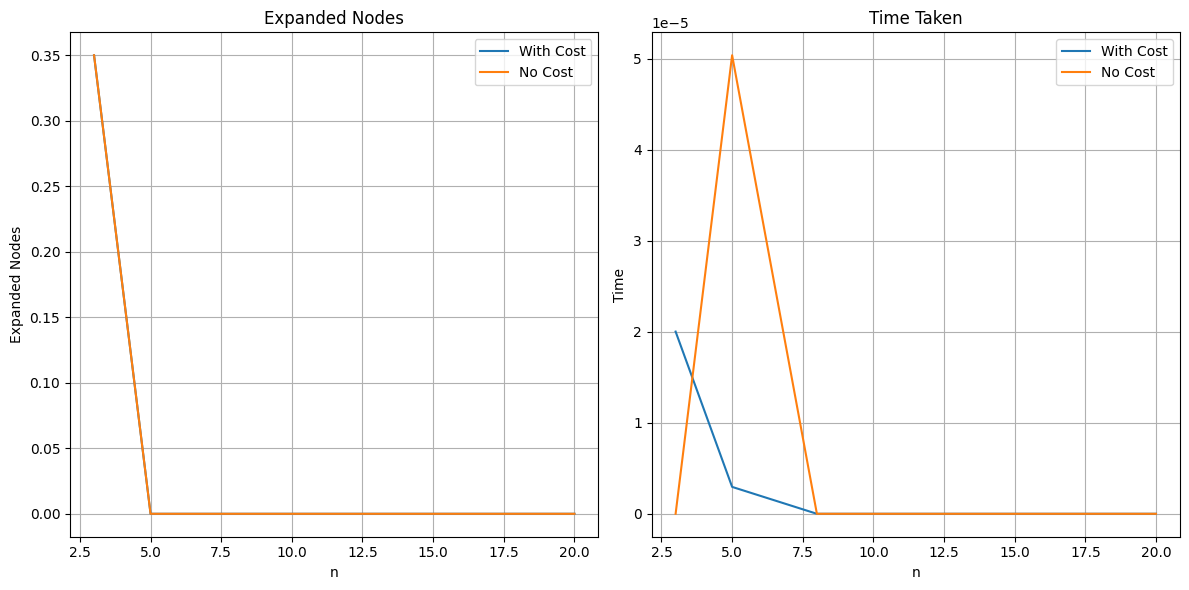

In [14]:
# Code for Question 3
# Place your code here
import random
import time
import matplotlib.pyplot as plt
from cspProblem import CSP

def generate_problem(n):
    days = ['mon', 'tue', 'wed', 'thu', 'fri']
    soft_constraints = ['early-morning', 'late-afternoon', 'midday', 'early-week', 'late-week']
    spec = []
    
    for i in range(n):
        meetings = f"meeting, m{i+1}"
        spec.append(meetings)
    for i in range(n - 1):
        ctype = random.choice(['before', 'same-day'])
        constraint = f"constraint, m{i+1} {ctype} m{i+2}"
        spec.append(constraint)
    for i in range(n):
        meetingname = f"m{i+1}"
        day = random.choice(days)
        hardconstraint = f"domain, {meetingname}, {day}, hard"
        spec.append(hardconstraint)
        softconstraint = random.choice(soft_constraints)
        softline = f"domain, {meetingname}, {softconstraint}, soft"
        spec.append(softline)
    return "\n".join(spec)

class CSearcher:
    def __init__(self, searcher):
        self.searcher = searcher
        self.nodes_expanded = 0 
    def search(self):
        result = self.searcher.search()
        while not self.searcher.frontier.empty():
            self.searcher.frontier.pop() 
            self.nodes_expanded=self.nodes_expanded+1  
        return result

def test_csp_solver(searcher, show_output=True):
    starttime = time.time()
    result = searcher.search()
    execution = time.time()-starttime
    if result is None:
        if show_output:
            print('No solution')
        return searcher.nodes_expanded, 0, execution  
    else:
        return searcher.nodes_expanded, result.cost, execution

def compare_performance(n_values, num_trials=20, show_output=True):
    nodes_withcost = []
    nodes_nocost = []
    times_withcost = []
    times_nocost = []
    for n in n_values:
        if show_output:
            print(f"Testing for n={n}")
        nodes_withcost_avg, nodes_nocost_avg, times_withcost_avg, times_nocost_avg = 0,0,0,0
        for i in range(num_trials):
            trial = show_output if i == 0 else False
            sample_spec = generate_problem(n)
            cspproblem_withcost = create_CSP_from_spec(sample_spec)
            solver_withcost = CSearcher(GreedySearcher(Search_with_AC_from_Cost_CSP(cspproblem_withcost)))
            nodesexpanded_withcost, cost_withcost, time_withcost = test_csp_solver(solver_withcost, trial)
            cspproblem_nocost = create_CSP_from_spec(sample_spec.replace('soft', 'no-cost'))
            solver_nocost = CSearcher(GreedySearcher(Search_with_AC_from_Cost_CSP(cspproblem_nocost)))
            nodesexpanded_nocost, cost_nocost, time_nocost = test_csp_solver(solver_nocost, trial)
            nodes_withcost_avg =nodes_withcost_avg+nodesexpanded_withcost
            nodes_nocost_avg=nodes_nocost_avg+nodesexpanded_nocost
            times_withcost_avg=times_withcost_avg+time_withcost
            times_nocost_avg=times_nocost_avg+time_nocost
            
        nodes_withcost.append(nodes_withcost_avg/num_trials)
        nodes_nocost.append(nodes_nocost_avg/num_trials)
        times_withcost.append(times_withcost_avg/num_trials)
        times_nocost.append(times_nocost_avg/num_trials)
    return nodes_withcost, nodes_nocost, times_withcost, times_nocost

def plot_results(n_values, nodes_withcost, nodes_nocost, times_withcost, times_nocost):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(n_values, nodes_withcost, label='With Cost')
    plt.plot(n_values, nodes_nocost, label='No Cost')
    plt.xlabel('n')
    plt.ylabel('Expanded Nodes')
    plt.title('Expanded Nodes')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(n_values, times_withcost, label='With Cost')
    plt.plot(n_values, times_nocost, label='No Cost')
    plt.xlabel('n')
    plt.ylabel('Time')
    plt.title('Time Taken')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

n_values = [3, 5, 8, 10, 13, 15, 18, 20]

nodes_withcost, nodes_nocost, times_withcost, times_nocost = compare_performance(n_values, num_trials=20, show_output=False)

performance_gain = [(n_without-n_with) / n_with * 100 if n_with != 0 else float('inf') for n_with, n_without in zip(nodes_withcost, nodes_nocost)]
print("gain with cost function (%):", performance_gain)

plot_results(n_values, nodes_withcost, nodes_nocost, times_withcost, times_nocost)


__Answers for Question 3__

In terms of the number of extended nodes, the number of nodes without cost functions is similar to those with cost functions, and in terms of Time Taken, the number of nodes with cost functions is less than those without cost functions.

### Question 4 (5 marks)

Compare the Depth-First Search (DFS) solver to the Depth-First Search solver using forward checking with Minimum Remaining Values heuristic (DFS-MRV). For this question, ignore the costs associated with the CSP problems. 

- What is the worst case time and space complexity of each algorithm? (1 mark)
- What are the properties of the search algorithms (completeness, optimality)? (1 mark)
- Give an example of a problem that is *easier* for the DFS-MRV solver than it is for the DFS solver, and explain why (1 mark)
- Empirically compare the quality of the first solution found by DFS and DFS-MRV compared to the optimal solution (1 marks)
- Empirically compare DFS-MRV with DFS in terms of the number of nodes expanded (1 mark)

For the empirical evaluations, run the two algorithms on a variety of problems of size `n` for varying `n`. Note that the domain splitting CSP solver with costs should always find an optimal solution.

__Answers for Question 4__

Assuming that b is the branching factor for each node, and d is the depth.

__1__:
What is the worst case time and space complexity of each algorithm?: 

1.DFS:

case time: O($b^d$)

space complexity: O(d)

2.DFS-MRV:

case time: O($b^d$)

space complexity: O(d)

__2__:
What are the properties of the search algorithms (completeness, optimality)?

1.DFS: 

completeness:If the search space is finite DFS complete. If there is infinite depth or loops, DFS is not complete.

optimality:DFS is not optimal because it may first find non optimal solutions.

2.DFS-MRV:

completeness:DFS-MRV is complete with the help of forward and backtracking.

optimality:DFS-MRV is not optimal

__3__:
Give an example of a problem that is easier for the DFS-MRV solver than it is for the DFS solver, and explain why:

Meeting scheduling issues, if some meetings can only be held during a specific time period on a certain day. In this case, the DFS-MRV solver using MRV heuristics will prioritize selecting the conference variable with the fewest remaining selectable values for allocation. However, DFS solvers may randomly select variables, resulting in redundant searches. DFS-MRV uses MRV to prioritize selecting the variable with the fewest remaining values each time.

__4__:
Empirically compare the quality of the first solution found by DFS and DFS-MRV compared to the optimal solution: 

DFS usually quickly finds the first solution. However, DFS-MRV is slower than DFS because it uses heuristics to select the optimal variables. However, the first solution found by DFS-MRV will have higher quality than the first solution found by DFS because it uses heuristics

__5__:
Empirically compare DFS-MRV with DFS in terms of the number of nodes expanded:

DFS：

Because DFS does not use any heuristics, it will expand more nodes.

DFS-MRV:

DFS-MRV reduces the exploration of invalid paths by selecting the most constrained variables and eliminating impossible values in advance.

### Question 5 (4 marks)

The DFS solver chooses variables in random order, and systematically explores all values for those variables in no particular order.

Incorporate costs into the DFS constraint solver. Similar to the cost function for the domain splitting solver, for a given variable *v*, the cost of assigning the value *val* to *v* is the total cost of violating all the soft constraints associated with *v* for the value *val*. The *minimum cost* for *v* is the lowest cost from amongst the values in the domain of *v*. The DFS solver should choose the variable *v* with lowest minimum cost, and explore its values in order of cost from lowest to highest.

- Implement this behaviour by modifiying the code in `dfs_solver` and place a copy of the code below (2 marks)
- Empirically compare the performance of DFS with and without these heuristics (2 marks)

For the empirical evaluations, again run the two algorithms on a variety of problems of size `n` for varying `n`.

In [15]:
def dfs_solver(constraints, domains, context, var_order, csp_with_cost=None):
    """ generator for all solutions to csp with potential cost calculation.
    """
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)} 
    if all(c.holds(context) for c in to_eval):
        if not var_order:  
            print("Nodes expanded to reach solution:", num_expanded)
            if csp_with_cost:
                total_cost = csp_with_cost.calculate_cost(context)
                print(f"cost: {total_cost}")
            yield context
        else:
            best_var = min(var_order, key=lambda var: min(
                sum(1 for constraint in constraints
                    if var in constraint.scope and constraint.can_evaluate(context | {var: val}) and not constraint.holds(context | {var: val}))
                for val in domains[var]
            ))
            sorted_values = sorted(domains[best_var], key=lambda val: sum(
                1 for constraint in constraints
                if best_var in constraint.scope and constraint.can_evaluate(context | {best_var: val}) and not constraint.holds(context | {best_var: val})
            ))

            for val in sorted_values:
                num_expanded =num_expanded+ 1
                yield from dfs_solver(constraints, domains, context | {best_var: val}, [v for v in var_order if v != best_var], csp_with_cost)

Running experiment for n = 1
meeting, m1
domain, m1, fri, hard
domain, m1, late-week, soft
Nodes expanded to reach solution: 1
cost: 0
meeting, m1
domain, m1, fri, hard
domain, m1, late-week, soft
Nodes expanded to reach solution: 1
meeting, m1
domain, m1, thu, hard
domain, m1, early-morning, soft
Nodes expanded to reach solution: 1
cost: 0
meeting, m1
domain, m1, thu, hard
domain, m1, early-morning, soft
Nodes expanded to reach solution: 1
meeting, m1
domain, m1, thu, hard
domain, m1, late-afternoon, soft
Nodes expanded to reach solution: 1
cost: 7
meeting, m1
domain, m1, thu, hard
domain, m1, late-afternoon, soft
Nodes expanded to reach solution: 1
meeting, m1
domain, m1, wed, hard
domain, m1, early-morning, soft
Nodes expanded to reach solution: 1
cost: 0
meeting, m1
domain, m1, wed, hard
domain, m1, early-morning, soft
Nodes expanded to reach solution: 1
meeting, m1
domain, m1, wed, hard
domain, m1, midday, soft
Nodes expanded to reach solution: 1
cost: 3
meeting, m1
domain, m1, we

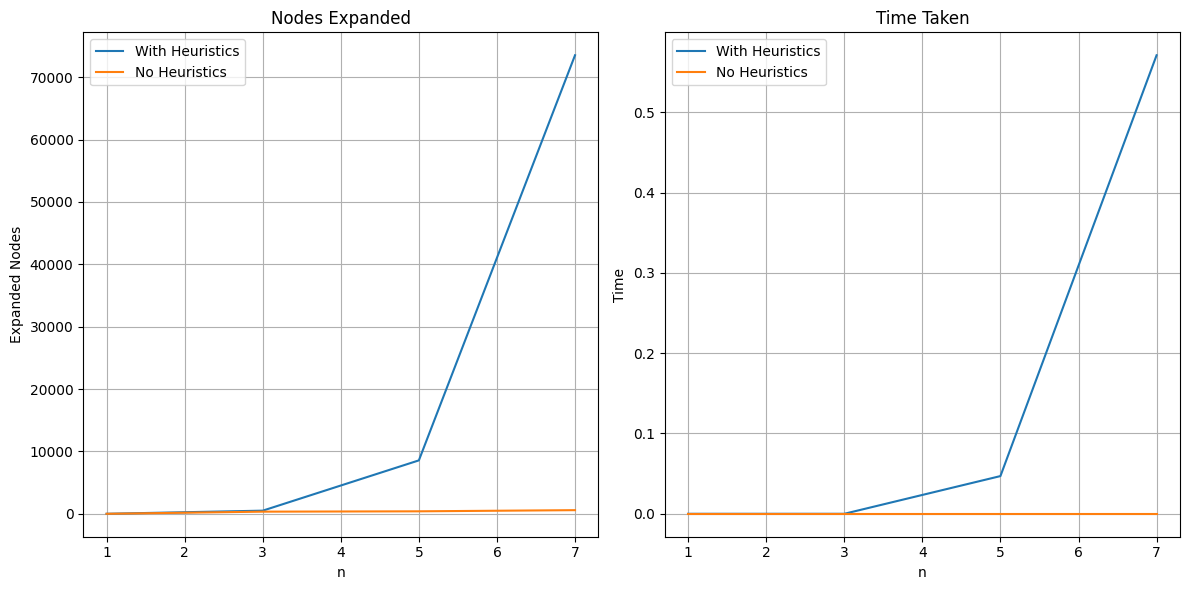

In [16]:
import random
import time
import matplotlib.pyplot as plt

num_expanded = 0
display = False

def dfs_solver(constraints, domains, context, var_order, csp_with_cost=None):
    """ generator for all solutions to csp with potential cost calculation.
    """
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)} 
    if all(c.holds(context) for c in to_eval):
        if not var_order:  
            print("Nodes expanded to reach solution:", num_expanded)
            if csp_with_cost:
                total_cost = csp_with_cost.calculate_cost(context)
                print(f"cost: {total_cost}")
            yield context
        else:
            best_var = min(var_order, key=lambda var: min(
                sum(1 for constraint in constraints
                    if var in constraint.scope and constraint.can_evaluate(context | {var: val}) and not constraint.holds(context | {var: val}))
                for val in domains[var]
            ))
            sorted_values = sorted(domains[best_var], key=lambda val: sum(
                1 for constraint in constraints
                if best_var in constraint.scope and constraint.can_evaluate(context | {best_var: val}) and not constraint.holds(context | {best_var: val})
            ))

            for val in sorted_values:
                num_expanded =num_expanded+ 1
                yield from dfs_solver(constraints, domains, context | {best_var: val}, [v for v in var_order if v != best_var], csp_with_cost)

def dfs_solver_no_heuristics(constraints, domains, context, var_order):
    """ generator for all solutions to csp """
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    if all(c.holds(context) for c in to_eval): 
        if var_order == []: 
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            var = var_order[0]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                yield from dfs_solver_no_heuristics(rem_cons, domains, context | {var: val}, var_order[1:])


def dfs_no_heuristics(csp, var_order=None):
    global num_expanded
    num_expanded = 0
    if var_order is None:
        var_order = list(csp.domains)
    for sol in dfs_solver_no_heuristics(csp.constraints, csp.domains, {}, var_order):
        return sol 
        
def dfs_solve1(csp, var_order=None):
    global num_expanded
    num_expanded = 0
    csp_with_cost = CSP_with_Cost(csp.domains, csp.constraints, csp.cost_functions)
    if var_order is None:   
        var_order = list(csp.domains)
    for sol in dfs_solver(csp.constraints, csp.domains, {}, var_order, csp_with_cost):
        return sol 

def compare_performance(n_values, num_trials=10):
    nodes_withheuristics = []
    nodes_noheuristics = []
    times_withheuristics = []
    times_noheuristics = []
    for n in n_values:
        print(f"Running experiment for n = {n}")
        nodes_withheuristics_avg = 0
        nodes_noheuristics_avg = 0
        times_withheuristics_avg = 0
        times_noheuristics_avg = 0
        for _ in range(num_trials):
            sample_spec = generate_problem(n)

            csp_with_cost = create_CSP_from_spec(sample_spec)
            global num_expanded
            num_expanded = 0
            starttime = time.time()
            dfs_solve1(csp_with_cost)
            time_withheuristics = time.time() - starttime
            nodes_withheuristics_avg = nodes_withheuristics_avg+num_expanded

            csp_no_cost = create_CSP_from_spec(sample_spec)
            num_expanded = 0
            starttime = time.time()
            dfs_no_heuristics(csp_no_cost)
            time_no_heuristics = time.time() - starttime
            nodes_noheuristics_avg=nodes_noheuristics_avg+num_expanded
        nodes_withheuristics.append(nodes_withheuristics_avg / num_trials)
        nodes_noheuristics.append(nodes_noheuristics_avg / num_trials)
        times_withheuristics.append(time_withheuristics)
        times_noheuristics.append(time_no_heuristics)

    return nodes_withheuristics, nodes_noheuristics, times_withheuristics, times_noheuristics

def plot_results(n_values, nodes_withheuristics, nodes_noheuristics, times_withheuristics, times_noheuristics):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(n_values, nodes_withheuristics, label='With Heuristics')
    plt.plot(n_values, nodes_noheuristics, label='No Heuristics')
    plt.xlabel('n')
    plt.ylabel('Expanded Nodes')
    plt.title('Nodes Expanded')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(n_values, times_withheuristics, label='With Heuristics')
    plt.plot(n_values, times_noheuristics, label='No Heuristics')
    plt.xlabel('n')
    plt.ylabel('Time')
    plt.title('Time Taken')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

n_values = [1, 3, 5, 7]


nodes_withheuristics, nodes_noheuristics, times_withheuristics, times_noheuristics = compare_performance(n_values, num_trials=10)

plot_results(n_values, nodes_withheuristics, nodes_noheuristics, times_withheuristics, times_noheuristics)



__Answers for Question 5__

Nodes Expanded: DFS with heuristic has fewer nodes expanded compared to DFS without heuristic, and when n is increasing, DFS with heuristic's nodes expanded increases quickly.

Time Taken: DFS with heuristic has fewer time taken compared to DFS without heuristic, and when n is increasing, DFS with heuristic's time taken increases quickly.

### Question 6 (3 marks)

The CSP solver with domain splitting splits a CSP variable domain into *exactly two* partitions. Poole & Mackworth claim that in practice, this is as good as splitting into a larger number of partitions. In this question, empirically evaluate this claim for the visitor hosting CSP.

- Write a new `partition_domain` function that partitions a domain into a list of `k` partitions, where `k` is a parameter to the function (1 mark)
- Modify the CSP solver to use the list of `k` partitions and evaluate the performance of the solver using the above metric for a range of values of `k` (2 marks) 

In [17]:
def partition_domain(domain, k):
    domain = list(domain) 
    size = len(domain) // k  
    partitions = []
    for i in range(k):
        if i==k-1:  
            partitions.append(domain[i*size:])
        else:
            partitions.append(domain[i*size*size:(i+1)])
    return partitions


n = 1
k = 2
meeting, m1
domain, m1, tue, hard
domain, m1, early-morning, soft
Nodes expanded to reach solution: 1
cost: 0
Nodes expanded to reach solution: 2
cost: 4
Nodes expanded to reach solution: 3
cost: 5
Nodes expanded to reach solution: 4
cost: 6
Nodes expanded to reach solution: 5
cost: 7
meeting, m1
domain, m1, tue, hard
domain, m1, midday, soft
Nodes expanded to reach solution: 1
cost: 3
Nodes expanded to reach solution: 2
cost: 1
Nodes expanded to reach solution: 3
cost: 2
Nodes expanded to reach solution: 4
cost: 3
Nodes expanded to reach solution: 5
cost: 4
meeting, m1
domain, m1, tue, hard
domain, m1, midday, soft
Nodes expanded to reach solution: 1
cost: 3
Nodes expanded to reach solution: 2
cost: 1
Nodes expanded to reach solution: 3
cost: 2
Nodes expanded to reach solution: 4
cost: 3
Nodes expanded to reach solution: 5
cost: 4
meeting, m1
domain, m1, mon, hard
domain, m1, early-week, soft
Nodes expanded to reach solution: 1
cost: 0
Nodes expanded to reach solution: 2
c

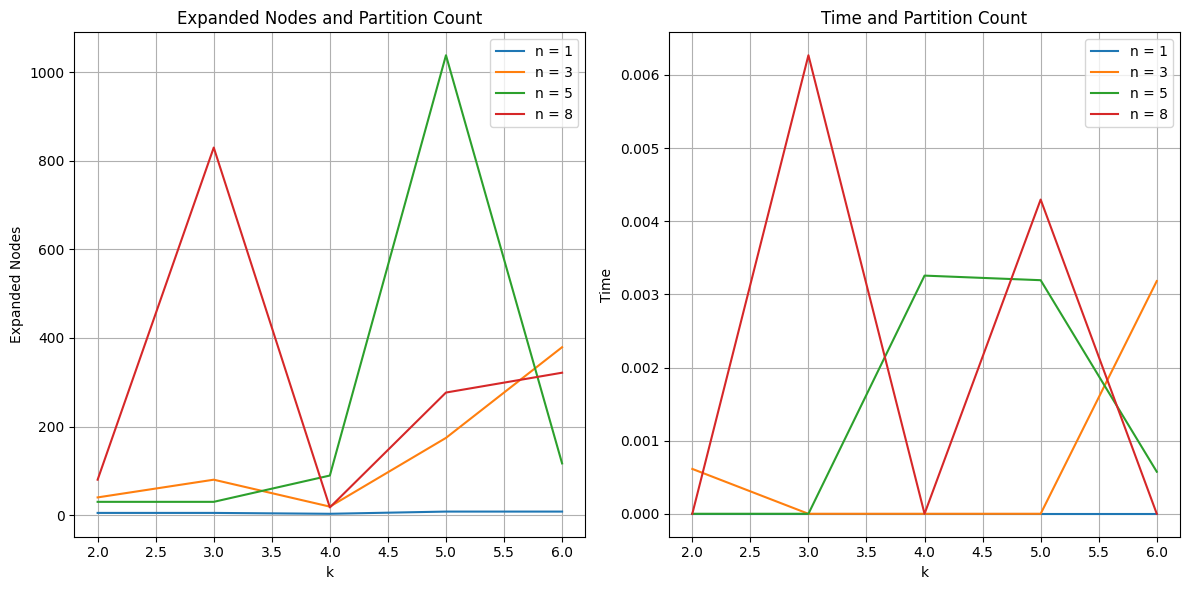

In [18]:
def partition_domain(domain, k):
    domain = list(domain) 
    size = len(domain) // k  
    partitions = []
    for i in range(k):
        if i==k-1:  
            partitions.append(domain[i*size:])
        else:
            partitions.append(domain[i*size*size:(i+1)])
    return partitions


def dfs_solver_partitioning(constraints, domains, context, var_order, k, csp_with_cost=None):
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    if all(c.holds(context) for c in to_eval):  
        if not var_order:  
            print("Nodes expanded to reach solution:", num_expanded)
            if csp_with_cost:
                total_cost = csp_with_cost.calculate_cost(context)
                print(f"cost: {total_cost}")
            yield context
        else:
            var = var_order[0]  
            partitions = partition_domain(domains[var], k)  
            for partition in partitions: 
                for val in partition:
                    num_expanded=num_expanded+1
                    yield from dfs_solver_partitioning(constraints, domains, context | {var: val}, var_order[1:], k, csp_with_cost)

def dfs_solve_partitioning(csp, k, var_order=None):
    global num_expanded
    num_expanded = 0
    if var_order is None:
        var_order = list(csp.domains)
    return list(dfs_solver_partitioning(csp.constraints, csp.domains, {}, var_order, k, csp))


def compare_partition_performance(n_values, k_values, num_trials=5):
    results = {}
    for n in n_values:
        print(f"n = {n}")
        for k in k_values:
            print(f"k = {k}")
            nodes = 0
            timea = 0
            for _ in range(num_trials):
                sample_spec = generate_problem(n)
                csp_with_cost = create_CSP_from_spec(sample_spec)
                global num_expanded
                num_expanded = 0
                starttime = time.time()
                dfs_solve_partitioning(csp_with_cost, k)
                elapsedtime = time.time() - starttime
                nodes =nodes+num_expanded
                timea =timea+elapsedtime
            nodes /= num_trials
            timea /= num_trials
            results[(n, k)] = (nodes, timea)
            print(f"Average expanded nodes: {nodes}, Average time: {timea}")
    
    return results

def plot_partition_results(results, n_values, k_values):
    plt.figure(figsize=(12, 6))
    for n in n_values:
        nodes = [results[(n, k)][0] for k in k_values]
        times = [results[(n, k)][1] for k in k_values]
        plt.subplot(1, 2, 1)
        plt.plot(k_values, nodes, label=f'n = {n}')
        plt.subplot(1, 2, 2)
        plt.plot(k_values, times, label=f'n = {n}')

    plt.subplot(1, 2, 1)
    plt.xlabel('k')
    plt.ylabel('Expanded Nodes')
    plt.title('Expanded Nodes and Partition Count')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.xlabel('k')
    plt.ylabel('Time')
    plt.title('Time and Partition Count')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
n_values = [1, 3, 5, 8]
k_values = [2, 3, 4, 5, 6]  

results = compare_partition_performance(n_values, k_values)

plot_partition_results(results, n_values, k_values)
